In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

Load Data Files

In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    """Load data from a CSV file."""
    return pd.read_csv(file_path)

In [3]:
anime_base_23 = load_data('../data/raw/anime-dataset-2023.csv')
anime_base_25 = load_data('../data/raw/anime-dataset-2025.csv')

watch_base_23 = load_data('../data/raw/users-score-2023.csv')
watch_base_25 = load_data('../data/raw/users-score-2025.csv')

In [4]:
print(f"Anime dataset 2023 shape: {anime_base_23.shape}")
print(f"Anime dataset 2025 shape: {anime_base_25.shape}")

print(f"Watchlist 2023 shape: {watch_base_23.shape}")
print(f"Watchlist 2025 shape: {watch_base_25.shape}")

Anime dataset 2023 shape: (24905, 24)
Anime dataset 2025 shape: (4643, 23)
Watchlist 2023 shape: (24325191, 5)
Watchlist 2025 shape: (24928042, 5)


Fix column names in 2025 anime dataset

In [5]:
anime_base_25.rename(columns={'animeID': 'anime_id'}, inplace=True)

Remove unused columns

In [6]:
def filter_anime_data(anime_df: pd.DataFrame) -> pd.DataFrame:
    """Filter relevant columns from anime data."""
    new_df = anime_df[['anime_id', 'Name', 'Genres', 'Type', 'Producers', 'Studios']]
    return new_df.set_index('anime_id')

def filter_watch_data(watch_df: pd.DataFrame) -> pd.DataFrame:
    """Filter relevant columns from watch data."""
    return watch_df[['user_id', 'anime_id', 'rating']]

In [7]:
anime_filtered_23 = filter_anime_data(anime_base_23)
anime_filtered_25 = filter_anime_data(anime_base_25)

watch_filtered_23 = filter_watch_data(watch_base_23)
watch_filtered_25 = filter_watch_data(watch_base_25)

Combine the Anime datasets

In [8]:
anime_combined = pd.concat([anime_filtered_23, anime_filtered_25], verify_integrity=True).drop_duplicates()
print(f"Combined anime dataset shape: {anime_combined.shape}")

Combined anime dataset shape: (29545, 5)


Plot the user's watch list data

In [9]:
watch_count_23 = watch_filtered_23.groupby('user_id')['anime_id'].nunique()
watch_count_25 = watch_filtered_25.groupby('user_id')['anime_id'].nunique()

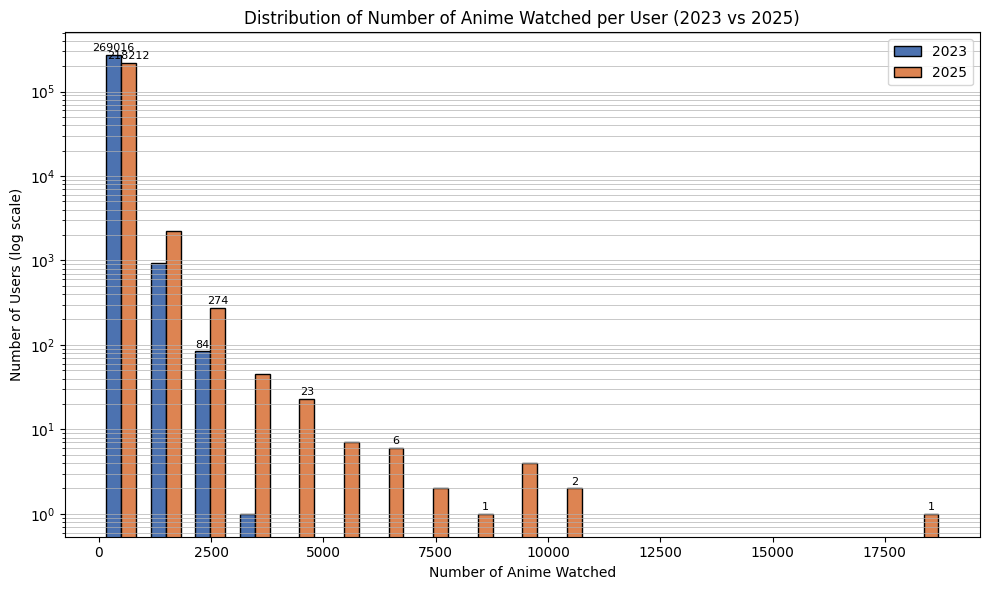

In [10]:
# Compute histogram data for both years
bins = np.linspace(
    min(min(watch_count_23), min(watch_count_25)),
    max(max(watch_count_23), max(watch_count_25)),
    20
)

counts_23, _ = np.histogram(watch_count_23, bins=bins)
counts_25, _ = np.histogram(watch_count_25, bins=bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot combined histogram
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = (bins[1] - bins[0]) / 3
bar1 = ax.bar(bin_centers - bar_width/2, counts_23, width=bar_width, 
              label="2023", color="#4C72B0", edgecolor='black')
bar2 = ax.bar(bin_centers + bar_width/2, counts_25, width=bar_width, 
              label="2025", color="#DD8452", edgecolor='black')

# Log scale and horizontal grid lines
ax.set_yscale('log')
ax.yaxis.grid(True, which='both', linestyle='-', linewidth=0.7, alpha=0.7)
ax.xaxis.grid(False)

# Labels and title
ax.set_title("Distribution of Number of Anime Watched per User (2023 vs 2025)")
ax.set_xlabel("Number of Anime Watched")
ax.set_ylabel("Number of Users (log scale)")
ax.legend()

# Add count labels on every second bar (only if count > 0)
for i, (rect1, rect2) in enumerate(zip(bar1, bar2)):
    if i % 2 == 0:
        if rect1.get_height() > 0:
            ax.text(rect1.get_x() + rect1.get_width()/2, rect1.get_height()*1.05,
                    f"{int(rect1.get_height())}", ha='center', va='bottom', fontsize=8)
        if rect2.get_height() > 0:
            ax.text(rect2.get_x() + rect2.get_width()/2, rect2.get_height()*1.05,
                    f"{int(rect2.get_height())}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Distributions of the watch data

In [11]:
print(f"2023 Watchlist - Min: {watch_count_23.min()}, Max: {watch_count_23.max()}, Avg: {watch_count_23.mean():.2f}")
print(f"2025 Watchlist - Min: {watch_count_25.min()}, Max: {watch_count_25.max()}, Avg: {watch_count_25.mean():.2f}")

2023 Watchlist - Min: 1, Max: 2986, Avg: 90.08
2025 Watchlist - Min: 1, Max: 18857, Avg: 112.89


In [12]:
lower_23 = watch_count_23.quantile(0.1)
upper_23 = watch_count_23.quantile(0.9)
lower_25 = watch_count_25.quantile(0.1)
upper_25 = watch_count_25.quantile(0.9)

print(f"2023 Watchlist - Lower 10% threshold: {lower_23}, Upper 10% threshold: {upper_23}")
print(f"2025 Watchlist - Lower 10% threshold: {lower_25}, Upper 10% threshold: {upper_25}")

2023 Watchlist - Lower 10% threshold: 2.0, Upper 10% threshold: 264.0
2025 Watchlist - Lower 10% threshold: 2.0, Upper 10% threshold: 297.0


Calculate dataset boundaries

In [13]:
lower_threshold, upper_threshold = lower_25, upper_25
print(f"Lower threshold: {lower_threshold}", f"Upper threshold: {upper_threshold}")

Lower threshold: 2.0 Upper threshold: 297.0


Clean the 2023 datasets using lower and upper boundary

In [14]:
watch_cleaned_23 = watch_filtered_23[watch_filtered_23['user_id'].isin(
    watch_count_23[(watch_count_23 >= lower_threshold) & (watch_count_23 <= upper_threshold)].index
)]

Make the 2025 watch list only contain users that are also appear in 2023

In [19]:
common_users = set(watch_cleaned_23['user_id']).intersection(set(watch_filtered_25['user_id']))

watch_shrunk_23 = watch_cleaned_23[watch_cleaned_23['user_id'].isin(common_users)]
watch_shrunk_25 = watch_filtered_25[watch_filtered_25['user_id'].isin(common_users)]

In [20]:
print (f"Number of common users in 2023 and 2025 watchlists: {len(common_users)}")

Number of common users in 2023 and 2025 watchlists: 110780


Save as processed

In [21]:
def save_preprocessed_data(df: pd.DataFrame, file_path: str, index: bool) -> None:
    """Save preprocessed data to a CSV file."""
    df.to_csv(file_path, index=index)

In [22]:
save_preprocessed_data(anime_filtered_23, '../data/clean/anime-dataset-2023.csv', True)
save_preprocessed_data(anime_combined, '../data/clean/anime-dataset-combined.csv', True)

save_preprocessed_data(watch_shrunk_23, '../data/clean/users-score-shrunk-2023.csv', False)
save_preprocessed_data(watch_shrunk_25, '../data/clean/users-score-shrunk-2025.csv', False)
save_preprocessed_data(watch_filtered_25, '../data/clean/users-score-2025.csv', False)